# **Creating anime characters using Deep Convolutional Generative Adversarial Networks (DCGANs) and PyTorch**

Imagine that you are working for a video game company known for its renowned games featuring unique characters tailored to each player. As the player base continues to expand, the task of manually designing characters for millions of players becomes nearly impossible. Your boss aims to maintain the ability to create distinct characters within the game, and you have been assigned the responsibility of finding a solution to address this challenge. <br>

__Generative adversarial networks (GANs) might help!__<br>
It is a class of machine learning frameworks, first published in June 2014 <a href=https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/papers/1406.2661.pdf >[1]</a>. <br>
GANs can generate new data that follows the statistical features of the data in the training set. GANs are widely used to generate new and realistic photographs that are authentic to human observers. <br>

Convolutional networks (CNNs) has seen huge adoption in computer vision applications. Applying the CNNs to GANs models could help us in building a photo generating model. The combined method is called Deep Convolutional Generative Adversarial Networks (DCGANs). <br>

# Table of Contents
1. Objectives
2. Setup
   1. Installing Required Libraries
   2. Importing Required Libraries
   3. Loading Pre-trained model (100 epochs)
   4. Defining Helper Functions
3. Basic: Generative Adversarial Networks (GANs)
   1. Introduction
   2. Toy Data
   3. The Generator
   4. The Loss Function GANs (Optional)
   5. Training GANs
4. Deep Convolutional Generative Adversarial Networks (DCGANs)
   1. Case background
   2. Loading the Dataset
   3. Creating Data Generator
   4. Generator and Discriminator (for DCGANs)
   5. Defining Loss Functions
   6. Defining Optimizers
   7. Create Train Step Function
   8. Training DCGANs

In [1]:
import urllib.request

url1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0A52EN/G_trained.pth"
url2 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0A52EN/D_trained.pth"

urllib.request.urlretrieve(url1, "G_trained.pth")
urllib.request.urlretrieve(url2, "D_trained.pth")

('D_trained.pth', <http.client.HTTPMessage at 0x1b9353ef820>)

In [2]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from  torch.distributions.multivariate_normal import MultivariateNormal
from torch.optim import lr_scheduler
from tqdm import tqdm
from IPython import display

import torchvision.utils as vutils
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from torchvision.transforms import ToPILImage


import os
from os import listdir
from pathlib import Path
import imghdr

In [3]:
# This function will allow us to easily plot data taking in x values, y values, and a title
def plot_distribution(real_data,generated_data,discriminator=None,density=True):

    plt.hist(real_data.numpy(), 100, density=density, facecolor='g', alpha=0.75, label='real data')
    plt.hist(generated_data.numpy(), 100, density=density, facecolor='r', alpha=0.75,label='generated data q(z) ')

    if discriminator:
        max_=torch.max(real_data.max(),generated_data.max().detach())
        min_=torch.min(real_data.min(),generated_data.min().detach())
        x=torch.linspace(start=min_, end=max_, steps=100)
        plt.plot(x.numpy(),discriminator(x.view(-1,1)).detach().view(-1).numpy(),label='discriminator',color='k')
        plt.plot(x.numpy(),0.5*np.ones(x.shape),label='0.5',color='b')
        plt.legend()
        plt.show()

In [4]:
# plot batch of images
def plot_image_batch(my_batch):

  fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(10, 10))
  img_num=0
  for i in range(8):
      for j in range(8):
          ax = axes[i][j]
          img_num+=1

          ax.imshow(np.transpose(vutils.make_grid(my_batch[img_num].to(device), padding=2, normalize=True).cpu(),(1,2,0)))
  plt.show()

In [5]:
def get_accuracy(X,Xhat):
    total=0
    py_x=D(X)
    total=py_x.mean()
    py_x=D(Xhat)
    total+=py_x.mean()
    return total/2

In [6]:
class Dataset(Dataset):
    def __init__(self, covariance_matrix, mean,n_samples=1000):
        self.obj =  MultivariateNormal(loc=mean, covariance_matrix=covariance_matrix)
        self.mean=mean
        self.covariance_matrix=covariance_matrix
        self.X=torch.tensor([[self.obj.sample()] for n in range(n_samples)])

    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):

        return self.X[idx,:]

In [7]:
n_samples=10000
mean=10*torch.ones(1)
covariance_matrix=0.1*torch.eye(1)

dataset=Dataset(covariance_matrix=covariance_matrix, mean=mean,n_samples=n_samples)

In [8]:
Z=torch.randn(n_samples,1)

In [9]:
print("mean:",Z.mean())
print("standard deviation:",Z.std())

mean: tensor(-0.0054)
standard deviation: tensor(0.9983)


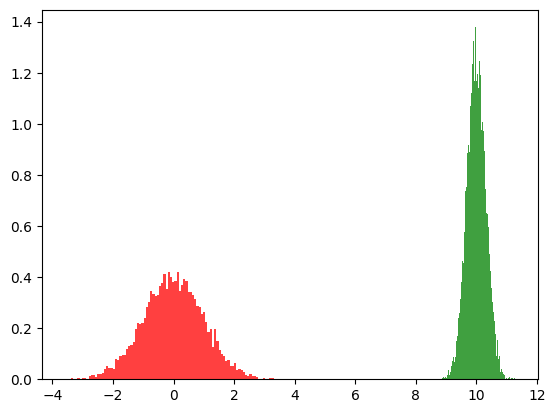

In [10]:
plot_distribution(real_data=dataset.X,generated_data=Z)

In [11]:
Xhat=Z+10

In [12]:
print("mean:",Xhat.mean())
print("standard deviation:",Xhat.std())

mean: tensor(9.9946)
standard deviation: tensor(0.9983)


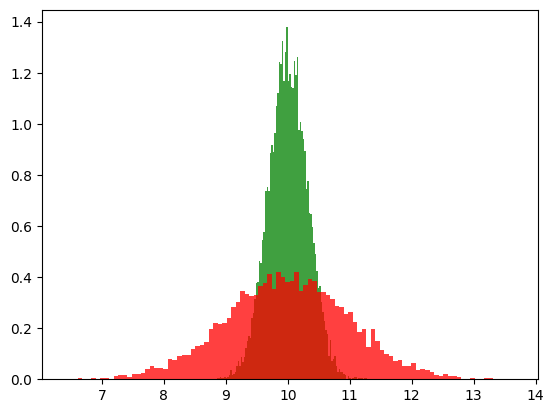

In [13]:
plot_distribution(real_data=dataset.X,generated_data=Xhat)

In [14]:
class Generator(nn.Module):
    def __init__(self,input_dim=1):
        super(Generator,self).__init__()
        self.l1=nn.Linear(1,input_dim)

    def forward(self, x):
        return self.l1(x)
G=Generator()

In [15]:
G

Generator(
  (l1): Linear(in_features=1, out_features=1, bias=True)
)

In [16]:
class Discriminator(nn.Module):
    def __init__(self,input_dim=1):
        super(Discriminator,self).__init__()
        self.l1=nn.Linear(1,input_dim)

    def forward(self, x):
        return torch.sigmoid(self.l1(x))

D=Discriminator()

In [17]:
D

Discriminator(
  (l1): Linear(in_features=1, out_features=1, bias=True)
)

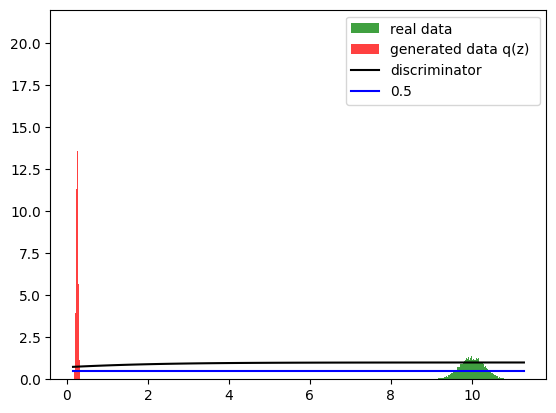

In [18]:
n_samples=1000
Xhat=G(torch.randn(n_samples,1))
plot_distribution(real_data=dataset.X,generated_data=Xhat.detach(),discriminator=D)

In [19]:
py_x=D(dataset.X)
torch.sum(py_x>0.5)/len(py_x)

tensor(1.)

In [20]:
py_x=D(Z)
torch.sum(py_x>0.5)/len(py_x)

tensor(0.9430)